In [1]:
# !pip install pmdarima

In [2]:
from pmdarima import auto_arima
import pandas as pd

# Load and preprocess data
data = pd.read_csv('./tes.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
hourly_requests = data['request'].resample('H').count()

C:\Users\apria.PLAINWHITE\AppData\Local\Temp\ipykernel_2100\1128031876.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_requests = data['request'].resample('H').count()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=8856.823, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=8728.582, Time=0.86 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=8756.010, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=9165.546, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=8729.612, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=8703.994, Time=8.87 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=8.39 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=8731.254, Time=0.50 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=8855.280, Time=1.37 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=8696.347, Time=11.10 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=8722.007, Time=0.57 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=8.98 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept   :

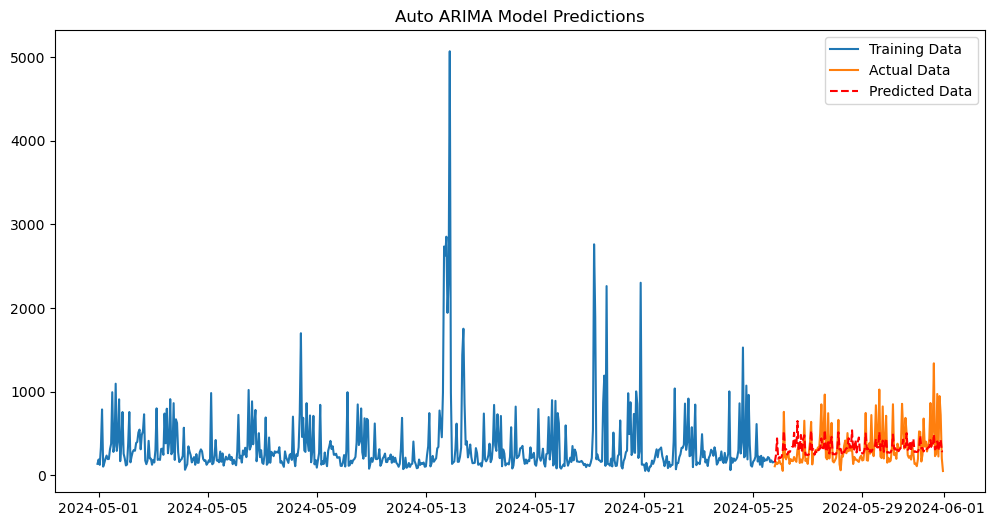

In [4]:
# Split data into training and test sets
train_size = int(len(hourly_requests) * 0.8)
train, test = hourly_requests[:train_size], hourly_requests[train_size:]

# Fit auto ARIMA model
auto_model = auto_arima(train, seasonal=True, m=24, trace=True, error_action='ignore', suppress_warnings=True)

# Make predictions
predictions = auto_model.predict(n_periods=len(test))
predicted_mean = pd.Series(predictions, index=test.index)

# Calculate residuals to identify anomalies
residuals = test - predicted_mean

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(predicted_mean.index, predicted_mean, color='red', linestyle='--', label='Predicted Data')
plt.legend()
plt.title('Auto ARIMA Model Predictions')
plt.show()

In [5]:
auto_model.predict_in_sample()

time
2024-04-30 23:00:00+07:00    358.500841
2024-05-01 00:00:00+07:00    255.458208
2024-05-01 01:00:00+07:00    260.675519
2024-05-01 02:00:00+07:00    219.058758
2024-05-01 03:00:00+07:00    304.958191
                                ...    
2024-05-25 14:00:00+07:00    228.830530
2024-05-25 15:00:00+07:00    388.243886
2024-05-25 16:00:00+07:00    135.119203
2024-05-25 17:00:00+07:00    246.068074
2024-05-25 18:00:00+07:00    229.961957
Freq: h, Name: predicted_mean, Length: 596, dtype: float64

In [6]:
pred = pd.concat([auto_model.predict_in_sample(), predictions])

In [7]:
res = hourly_requests - pred

In [8]:
threshold = 3*res.std()
anomalies = res[abs(res) > threshold]

In [9]:
anomalies

time
2024-05-08 10:00:00+07:00    1224.930687
2024-05-13 16:00:00+07:00    2152.119206
2024-05-13 17:00:00+07:00    1346.648774
2024-05-13 18:00:00+07:00    1354.585169
2024-05-13 21:00:00+07:00    3398.725584
2024-05-13 22:00:00+07:00   -1449.575848
2024-05-13 23:00:00+07:00   -1030.612929
2024-05-14 00:00:00+07:00    -962.526479
2024-05-14 08:00:00+07:00    1174.787509
2024-05-14 09:00:00+07:00    1028.625080
2024-05-19 04:00:00+07:00    2540.525796
2024-05-19 15:00:00+07:00    1742.703987
2024-05-19 16:00:00+07:00   -1082.480925
2024-05-20 21:00:00+07:00    1811.733918
dtype: float64

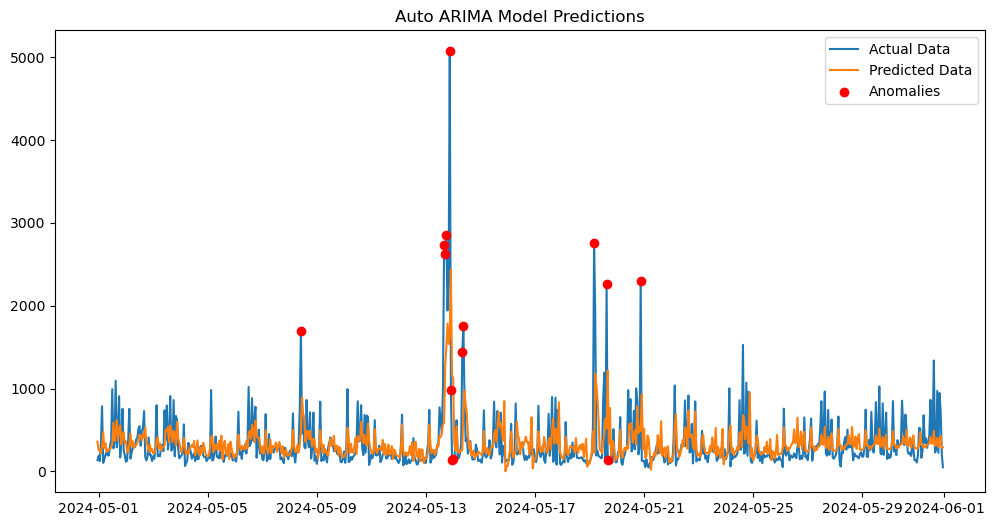

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_requests.index, hourly_requests, label='Actual Data')
plt.plot(pred.index, pred, label='Predicted Data')
plt.scatter(anomalies.index, hourly_requests[anomalies.index], color='red', label='Anomalies', zorder=5)
# plt.plot(predicted_mean.index, predicted_mean, color='red', linestyle='--', label='Predicted Data')
plt.legend()
plt.title('Auto ARIMA Model Predictions')
plt.show()

In [11]:
# Retrieve IPs that accessed the site during the anomaly times
anomalous_times = anomalies.index
anomalous_ips = data.loc[data.index.isin(anomalous_times)]

# Count the frequency of IPs during anomaly times
ip_frequency = anomalous_ips['ip'].value_counts()

In [12]:
from datetime import datetime, timedelta

In [13]:
anomalous_times[0]

Timestamp('2024-05-08 10:00:00+0700', tz='UTC+07:00')

In [14]:
anomalous_times[0]+timedelta(hours=1)

Timestamp('2024-05-08 11:00:00+0700', tz='UTC+07:00')

In [15]:
data['time'] = data.index

In [16]:
data['rounded_time'] = data['time'].dt.floor('h')

In [17]:
anomalous_ips = data.loc[data['rounded_time'].isin(anomalous_times), ['ip','rounded_time', 'time']]\
    .groupby(['rounded_time', 'ip'])\
    .count()\
    .sort_values('rounded_time', ascending=False)

In [18]:
anomalous_ips[anomalous_ips.time > 100]

time
rounded_time              ip           
2024-05-20 21:00:00+07:00 ip-150    200
                          ip-7361  1894
2024-05-19 15:00:00+07:00 ip-6908  2076
                          ip-2      102
2024-05-19 04:00:00+07:00 ip-6828  2662
2024-05-14 09:00:00+07:00 ip-4984   919
                          ip-3767   505
                          ip-2      125
2024-05-14 08:00:00+07:00 ip-4984   738
                          ip-3767   507
2024-05-13 23:00:00+07:00 ip-2      123
2024-05-13 22:00:00+07:00 ip-3767   323
                          ip-4984   563
2024-05-13 21:00:00+07:00 ip-5029  3952
                          ip-4984   209
                          ip-3767   183
                          ip-150    184
                          ip-149    197
                          ip-153    236
2024-05-13 18:00:00+07:00 ip-5029  1973
                          ip-153    143
                          ip-150    459
                          ip-149    126
2024-05-13 17:00:00+07:00 ip-5029  2416
2024-05-13 16:00:00+07:00 ip-3767   247
                          ip-5029  2168
2024-05-08 10:00:00+07:00 ip-3585   801
                          ip-15     648